In [18]:
# handling all imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn.metrics as metrics
from sklearn.tree import DecisionTreeClassifier
from statsmodels.stats.contingency_tables import mcnemar
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier
warnings.filterwarnings('ignore')

First, lets load and explore the dataset

In [19]:
pima = pd.read_csv('diabetes.csv')
pima.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


So, the dataset consists of 8 predictor variables and two classes 1 and 0. 1 means the person has diabetes and 0 means the person is healthy.
First of all, lets check for outliers and any missing data.

In [20]:
print(pima.shape)
print(pima.info())
pima.describe().T

(768, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


As we can see, there are no missing values, as the shape is (768, 9) and for each column there are 768 non-null values. However, there are some values which maybe considered as missing. For example, the minimum values for glucose, blood pressure, skin thickness, insulin and BMI are zeros, which is impossible to be observed in a living person. Let's see how many are those values in the dataset. Let' also check the dataset for outliers.

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64
Duplicated values: 0


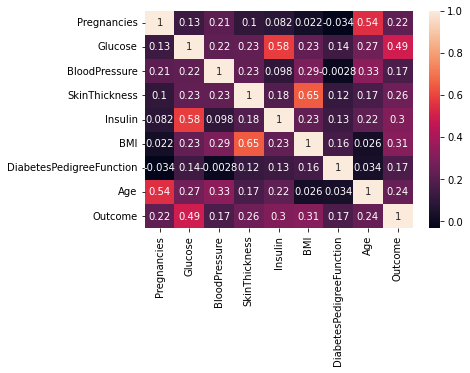

In [21]:
zero_columns = ["Glucose", "BloodPressure","SkinThickness","Insulin", "BMI"]
pima[zero_columns] = pima[zero_columns].replace({0:np.nan})
print(pima.isnull().sum())
print("Duplicated values: " + str(pima.duplicated().sum()))
sns.heatmap(pima.corr(), annot=True)
plt.show()

Here, we treated zero values as missing values, by replacing them with NaN. So, pandas can now identify missing values and count them. As we can see, there are quite a lot of them, especially for Insulin, so simply removing them from a dataset will cause a significant loss of data. The way to treat those missing values is to impute them with mean or median depending on how the data is scewed. We will plot boxplots and distirbution plots to find the best imputing technique.

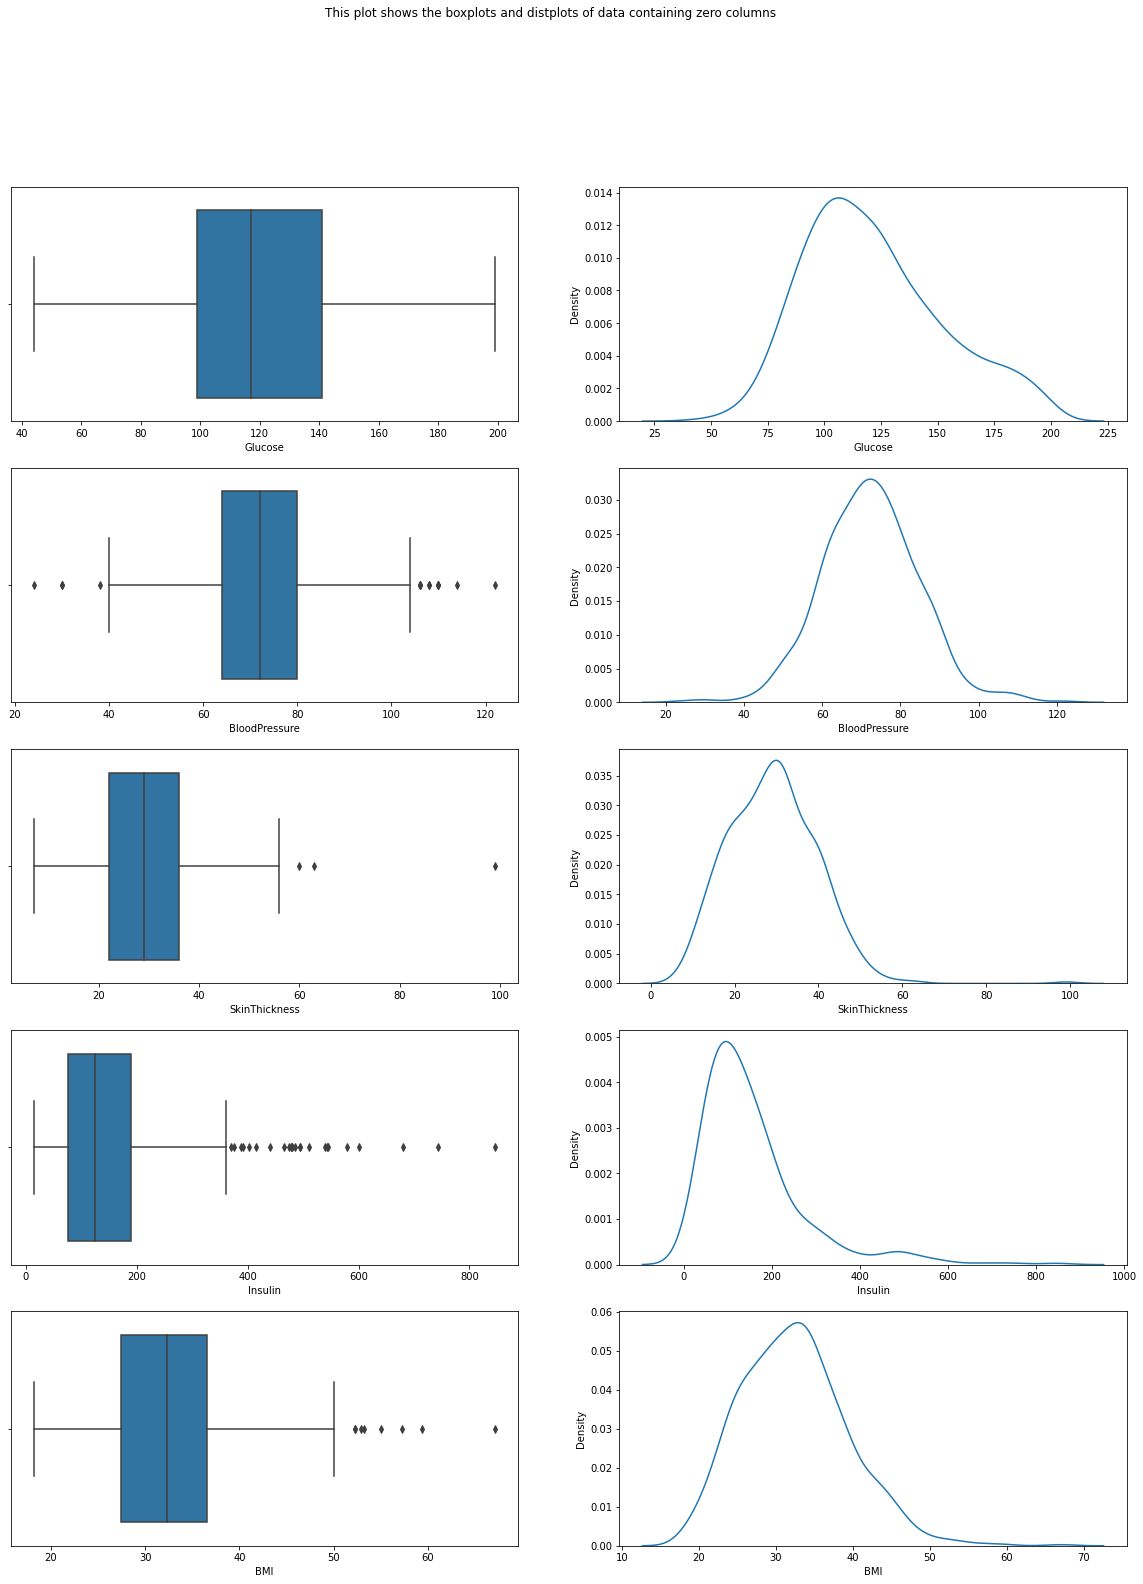

In [22]:
fig, axes = plt.subplots(ncols=2, nrows=5, figsize=(20, 25))

for i, ax in zip(zero_columns, axes):
    sns.boxplot(pima[i], ax=ax[0])
    sns.distplot(pima[i], hist=False, ax=ax[1])
plt.suptitle("This plot shows the boxplots and distplots of data containing zero columns")
plt.show()

So, as we can see from the box and dist plots, we can use mean impute technique on glucose column, as there are no outliers to affect the mean as well as the data is clearly not skewed very much. The blood pressure data is pretty much normally distirbuted, so mean imputation will fit best here. All other columns show a strong right-skeweness as well as a lot of outliers, so it is best to use median or mode imputation. For this dataset I will use median imputation.

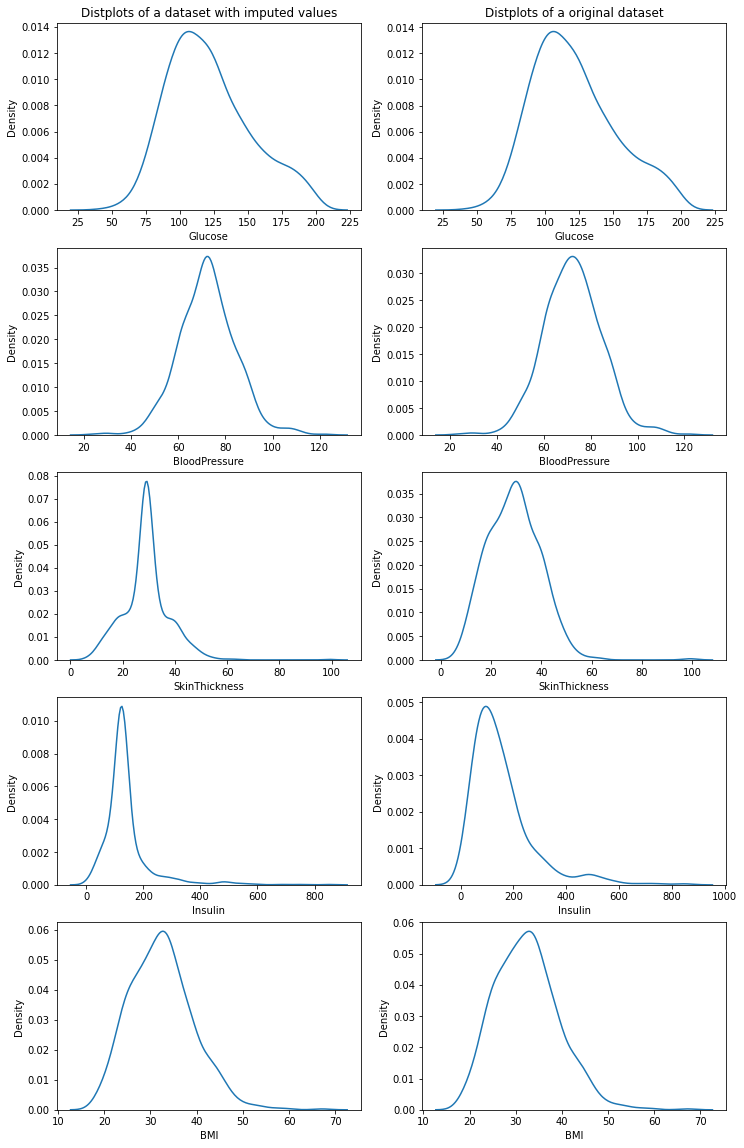

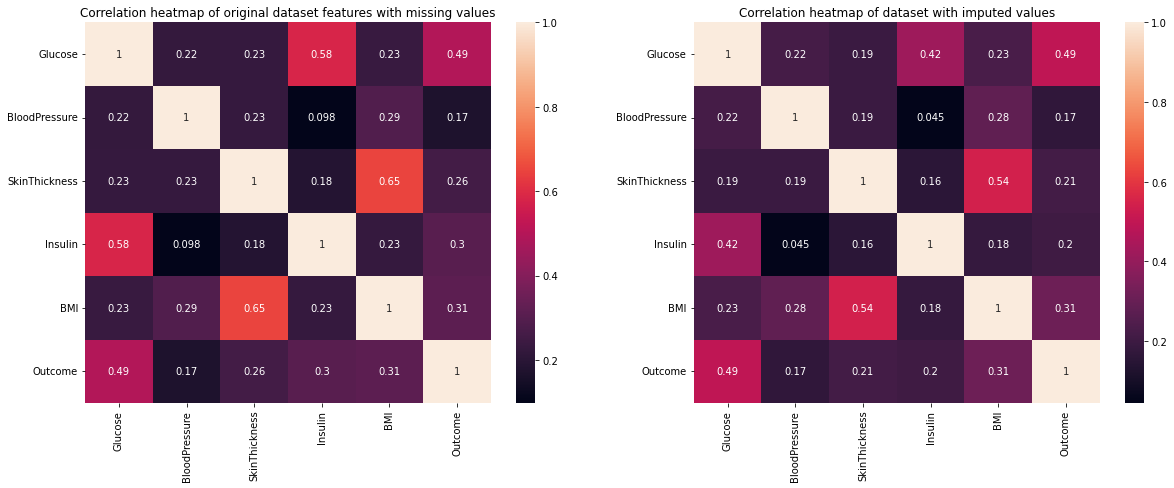

In [36]:
# ["Glucose", "BloodPressure","SkinThickness","Insulin", "BMI"]
pima_cp = pima.copy(deep=True)
pima_cp['Glucose'].fillna(pima_cp['Glucose'].mean(), inplace=True)
pima_cp['BloodPressure'].fillna(pima_cp['BloodPressure'].mean(), inplace=True)
pima_cp['SkinThickness'].fillna(pima_cp['SkinThickness'].median(), inplace=True)
pima_cp['Insulin'].fillna(pima_cp['Insulin'].median(), inplace=True)
pima_cp['BMI'].fillna(pima_cp['BMI'].median(), inplace=True)

fig, axes = plt.subplots(ncols=2, nrows=5, figsize=(12, 20))
axes[0][0].title.set_text("Distplots of a dataset with imputed values")
axes[0][1].title.set_text("Distplots of a original dataset")
for i, ax in zip(zero_columns, axes):
    sns.distplot(pima_cp[i], hist=False, ax=ax[0])
    sns.distplot(pima[i], hist=False, ax=ax[1])
plt.show()



f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))
ax[0].title.set_text("Correlation heatmap of original dataset features with missing values")
ax[1].title.set_text("Correlation heatmap of dataset with imputed values")
sns.heatmap(pima[["Glucose", "BloodPressure","SkinThickness","Insulin", "BMI", 'Outcome']].corr(), annot=True, ax=ax[0])
sns.heatmap(pima_cp[["Glucose", "BloodPressure","SkinThickness","Insulin", "BMI", 'Outcome']].corr(), annot=True, ax=ax[1])
X = pima_cp.iloc[:,:-1].to_numpy()
y = pima_cp['Outcome'].to_numpy()

As we can see from new dist plots the new data with imputed zero values did not change pretty much. All the patters are matched even for insulin, where were most of the missing values. This means, that our imputed data did not make a strong change in bias. Let's also double check that we indeed filled all missing values.

In [ ]:
pima_cp.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Indeed, all null values were replaced and now we have a complete dataset. Now, lets find out how imbalanced our dataset is.

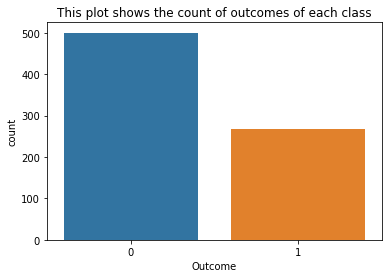

In [ ]:
sns.countplot(x='Outcome', data=pima_cp)
plt.title("This plot shows the count of outcomes of each class")
plt.show()

From the countplot we see that the 1 outcome occurs almost half as less as outcome 0. This is not that good, assuming that our dataset is relatively small. We would expect some bias in classification and a low recall rate, so it is better to balance the dataset before modelling. There are two main approaches to address dataset imbalance: undersampling and oversampling. As pima dataset is not very large, undersampling is not really desired approach as it will generate a huge loss of data and thus a worse classification perfomance. We tried to do oversampling using ```SMOTE``` algorithm. In order to make sure, that oversampling did not generate some strong correlation between features, we will compare correlation matrices before and after oversampling. If the matrices are almost identical, then oversampling did not change much in the relation between features.

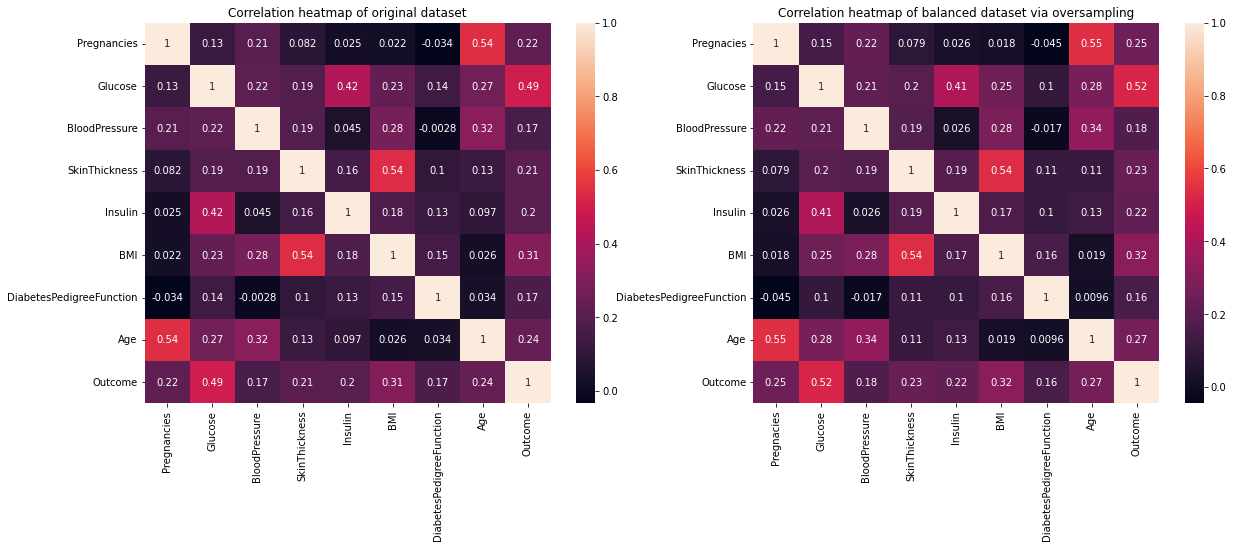

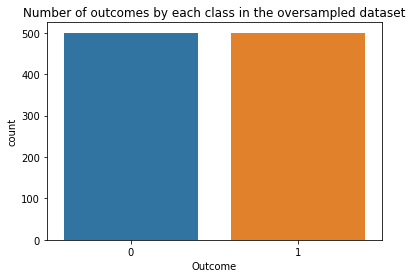

In [ ]:
pima_unbalanced = pima_cp.copy(deep=True)
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))
ax[0].title.set_text("Correlation heatmap of original dataset")
ax[1].title.set_text("Correlation heatmap of balanced dataset via oversampling")
sns.heatmap(pima_unbalanced.corr(), annot=True, ax=ax[0])
X = pima_unbalanced.iloc[:,:-1].to_numpy()
y = pima_unbalanced['Outcome'].to_numpy()

smote = SMOTE(random_state=0)
X_os, y_os = smote.fit_resample(X, y)
pima_oversampled = pd.DataFrame({'Pregnacies':X_os[:,0],
                                'Glucose':X_os[:,1],
                                'BloodPressure':X_os[:,2],
                                'SkinThickness':X_os[:,3],
                                'Insulin':X_os[:,4],
                                'BMI':X_os[:,5],
                                'DiabetesPedigreeFunction':X_os[:,6],
                                'Age':X_os[:,7],
                                'Outcome':y_os})
sns.heatmap(pima_oversampled.corr(), annot=True, ax=ax[1])
plt.show()
sns.countplot(x='Outcome', data=pima_oversampled)
plt.title("Number of outcomes by each class in the oversampled dataset")
plt.show()

As we can see, the correlation matrices are almost the same, so oversampling did not make any significant difference in the relation between features. Also on a countplot we can see that there are same number of outcomes by each class, this makes the new dataset perfectly balanced.

Here we created a balanced pima dataset which we will use to compare classifier perfomance with inbalanced dataset. Now, let's split the dataset on a train and test sets and initialize ```GaussianNB``` classifier. 

AUC of NB classifier: 0.864494301994302
Precison of NB classifier: 0.7777777777777778
Recall of NB classifier: 0.7291666666666666


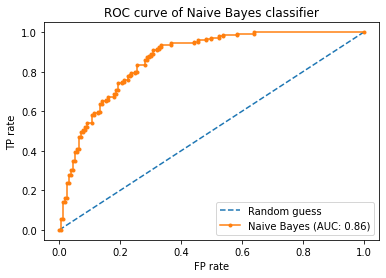

In [ ]:
def evaluate_model (X_train, X_test, y_train, y_test, model, additional = "", verbose=True, label='', nrg = True):
    model.fit(X_train, y_train)
    lr_probs = model.predict_proba(X_test)
    lr_probs = lr_probs[:,1]
    ns_probs = [0 for _ in range(len(y_test))]
    ns_fpr, ns_tpr, _ = metrics.roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = metrics.roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    lr_auc_unb = metrics.roc_auc_score(y_test, lr_probs)
    if nrg:
        plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Random guess')
    plt.plot(lr_fpr, lr_tpr, marker='.', label=label + " (AUC: {a})".format(a=round(lr_auc_unb, 2)))
    plt.legend(loc='lower right')
    plt.xlabel("FP rate")
    plt.ylabel("TP rate")
    y_pred = model.predict(X_test)
    prec_und = metrics.precision_score(y_test, y_pred)
    recall_und = metrics.recall_score(y_test, y_pred)
    if verbose:
        print("AUC {ad}: ".format(ad=additional)+str(lr_auc_unb))
        # print("AUC balanced: "+str(metrics.roc_auc_score(y_test, lr_probs)))
        # print("Precison of balanced data: "+str(metrics.precision_score(y_test, y_pred)))
        print("Precison {ad}: ".format(ad=additional)+str(prec_und))
        # print("Recall of balanced data: "+str(metrics.recall_score(y_test, y_pred)))
        print("Recall {ad}: ".format(ad=additional)+str(recall_und))
    return metrics.confusion_matrix(y_test, y_pred), lr_auc_unb, prec_und, recall_und

X_train, X_test, y_train, y_test = train_test_split(X_os, y_os, test_size=0.3, random_state=0)
evaluate_model(X_train, X_test, y_train, y_test, GaussianNB(), additional='of NB classifier', label='Naive Bayes')
# X = pima_balanced.iloc[:,:-1].to_numpy()
# y = pima_balanced['Outcome'].to_numpy()

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
# model = GaussianNB()
# model.fit(X_train, y_train)
# expected = y_test
# predicted = model.predict(X_test)
# lr_probs = model.predict_proba(X_test)
# lr_probs = lr_probs[:,1]    
# ns_probs = [0 for _ in range(len(y_test))]
# ns_fpr, ns_tpr, _ = metrics.roc_curve(y_test, ns_probs)
# lr_fpr, lr_tpr, _ = metrics.roc_curve(y_test, lr_probs)
# # plot the roc curve for the model
# plt.plot(lr_fpr, lr_tpr, marker='.', label='Naive Bayes balanced')
# plt.legend()

plt.title("ROC curve of Naive Bayes classifier")
plt.show()

As we can see by the ROC curve and AUC scores, the model performs quite good. The recall and precision measures are also quite high. Let's now see for the Decision Tree classifier.

First I will decide the best depth of a tree in order to prevent under or overfitting. I will test on a set of values from 2 to 9 and plot the errors of test set and train set. The best depth should be where the error rate of test set starts growing.

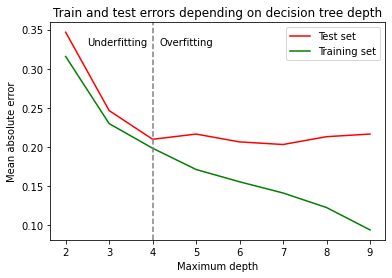

In [ ]:
depths = np.arange(2, 10)
error_rate_test = []
error_rate_training = []
for d in depths:
    clf_unb = DecisionTreeClassifier(max_depth=d, criterion='entropy', random_state=0)
    clf_unb.fit(X_train, y_train)
    y_pred_train = clf_unb.predict(X_train)
    y_pred_test = clf_unb.predict(X_test)
    error_rate_test.append(metrics.mean_absolute_error(y_test, y_pred_test))
    error_rate_training.append(metrics.mean_absolute_error(y_train, y_pred_train))

plt.plot(depths, error_rate_test, c='red')
plt.plot(depths, error_rate_training, c='green')
plt.axvline(x=4, color='gray', linestyle='--')
plt.text(2.5, 0.33, 'Underfitting')
plt.text(4.15, 0.33, 'Overfitting')
plt.xlabel("Maximum depth")
plt.ylabel("Mean absolute error")
plt.title("Train and test errors depending on decision tree depth")
plt.legend(['Test set', 'Training set'])
plt.show()

AUC of DT classifier: 0.8478899572649572
Precison of DT classifier: 0.7515527950310559
Recall of DT classifier: 0.8402777777777778


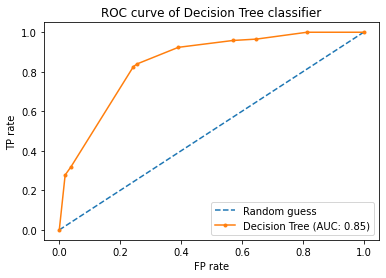

In [ ]:
evaluate_model(X_train, X_test, y_train, y_test, DecisionTreeClassifier(max_depth=4, criterion='entropy', random_state=0), additional='of DT classifier', 
label='Decision Tree')
# model.fit(X_train, y_train)
# expected = y_test
# predicted = model.predict(X_test)
# lr_probs = model.predict_proba(X_test)
# lr_probs = lr_probs[:,1]
# ns_probs = [0 for _ in range(len(y_test))]
# ns_fpr, ns_tpr, _ = metrics.roc_curve(y_test, ns_probs)
# lr_fpr, lr_tpr, _ = metrics.roc_curve(y_test, lr_probs)
# # plot the roc curve for the model
# plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Random guess')
# plt.plot(lr_fpr, lr_tpr, marker='.', label='Decision Tree classifier unbalanced')
# plt.legend()
# lr_auc_unb = metrics.roc_auc_score(y_test, lr_probs)
# y_pred = model.predict(X_test)
# prec_und = metrics.precision_score(y_test, y_pred)
# recall_und = metrics.recall_score(y_test, y_pred)

# X = pima_balanced.iloc[:,:-1].to_numpy()
# y = pima_balanced['Outcome'].to_numpy()

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
# model = DecisionTreeClassifier(max_depth=3, criterion='entropy', random_state=0)
# model.fit(X_train, y_train)
# expected = y_test
# predicted = model.predict(X_test)
# lr_probs = model.predict_proba(X_test)
# lr_probs = lr_probs[:,1]    
# ns_probs = [0 for _ in range(len(y_test))]
# ns_fpr, ns_tpr, _ = metrics.roc_curve(y_test, ns_probs)
# lr_fpr, lr_tpr, _ = metrics.roc_curve(y_test, lr_probs)
# # plot the roc curve for the model
# plt.plot(lr_fpr, lr_tpr, marker='.', label='Decision Tree classifier balanced')
# plt.legend()
# plt.xlabel("FP rate")
# plt.ylabel("TP rate")
plt.title("ROC curve of Decision Tree classifier")
plt.show()

# y_pred = model.predict(X_test)
# print("AUC unbalanced: "+str(lr_auc_unb))
# print("AUC balanced: "+str(metrics.roc_auc_score(y_test, lr_probs)))
# print()
# print("Precison of balanced data: "+str(metrics.precision_score(y_test, y_pred)))
# print("Precison of unbalanced data: "+str(prec_und))
# print()
# print("Recall of balanced data: "+str(metrics.recall_score(y_test, y_pred)))
# print("Recall of unbalanced data: "+str(recall_und))

The results are very optimistic. The overall perfomance of Decision Tree is good as well as we have a very high rate of recall, namely 84%. This means that this model will correctly predict if person has diabetes in 84% cases.

Let's compare the perfomance of these two classifiers using McNemar test on balanced and unbalanced data

In [40]:
M1 = GaussianNB()
M2 = DecisionTreeClassifier(max_depth=4, criterion='entropy', random_state=0)
Dummy = DummyClassifier(strategy='most_frequent')

M1_pred = M1.fit(X_train, y_train).predict(X_test)
M2_pred = M2.fit(X_train, y_train).predict(X_test)
baseline = Dummy.fit(X_train, y_train).predict(X_test)



def mcnemar_compare_models(pred1, pred2):
    cor_m1_m2 = 0
    cor_m1_wr_m2 = 0
    cor_m2_wr_m1 = 0
    wr_m1_m2 = 0

    for corr, pred_m1, pred_m2 in zip(y_test, pred1, pred2):
        if pred_m1 == pred_m2 == corr:
            cor_m1_m2 += 1
        elif pred_m1 == corr and pred_m2 != corr:
            cor_m1_wr_m2 += 1
        elif pred_m1 != corr and pred_m2 == corr:
            cor_m2_wr_m1 += 1
        elif pred_m2 != corr and pred_m1 != corr:
            wr_m1_m2 += 1
    cont_t = np.array([[cor_m1_m2, cor_m1_wr_m2], [cor_m2_wr_m1, wr_m1_m2]])
    # sns.heatmap(cont_t, annot=True)
    # plt.show()
    return cont_t

M1vM2 = mcnemar_compare_models(M1_pred, M2_pred)
M1vBaseline = mcnemar_compare_models(M1_pred, baseline)
M2vBaseline = mcnemar_compare_models(M2_pred, baseline)

print("McNemar compare DT and NB")
print(mcnemar(M1vM2, exact=False))
print()
print("McNemar compare DT and baseline")
print(mcnemar(M1vBaseline, exact=False))
print()
print("McNemar compare DT and baseline")
print(mcnemar(M2vBaseline, exact=False))

McNemar compare DT and NB
pvalue      0.544289624429402
statistic   0.36764705882352944

McNemar compare DT and baseline
pvalue      2.155375812484173e-11
statistic   44.82424242424243

McNemar compare DT and baseline
pvalue      6.02907129079485e-15
statistic   60.89208633093525


As we can see, the p-value when comparing DT and NB classifiers is greater than 0.05, this means that classifier's perfomance is not significantly different from each other. However, comparing both classifiers with baseline yields p-values much more less that 0.05 meaning there is a significant difference in their performance. This means, that both classifiers performed well in our dataset. Now, let's compare both classifiers by using standart metrics like confusion matrix and ROC curves. We will call Decision Tree classifier as DT and Naive Bayes as NB for consistency.

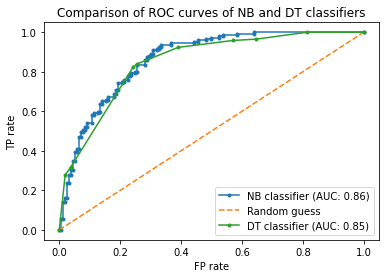

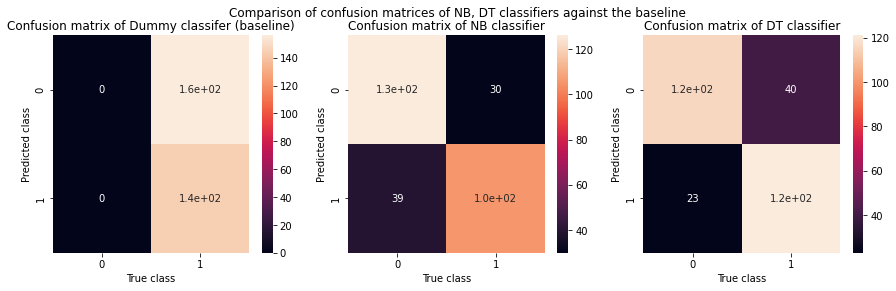

Classification report for Dummy classifier (baseline):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       156
           1       0.48      1.00      0.65       144

    accuracy                           0.48       300
   macro avg       0.24      0.50      0.32       300
weighted avg       0.23      0.48      0.31       300


Classification report for NB:
              precision    recall  f1-score   support

           0       0.76      0.81      0.79       156
           1       0.78      0.73      0.75       144

    accuracy                           0.77       300
   macro avg       0.77      0.77      0.77       300
weighted avg       0.77      0.77      0.77       300


Classification report for DT:
              precision    recall  f1-score   support

           0       0.83      0.74      0.79       156
           1       0.75      0.84      0.79       144

    accuracy                           0.79       300
   macro av

In [ ]:
evaluate_model(X_train, X_test, y_train, y_test, GaussianNB(), verbose=False, nrg=False, label='NB classifier')
evaluate_model(X_train, X_test, y_train, y_test, DecisionTreeClassifier(max_depth=4, criterion='entropy', random_state=0), verbose=False, label='DT classifier')
plt.title("Comparison of ROC curves of NB and DT classifiers")
plt.show()

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

M1 = GaussianNB()
M2 = DecisionTreeClassifier(max_depth=4, criterion='entropy', random_state=0)
Dummy = DummyClassifier(strategy='most_frequent')

Dummy.fit(X_train, y_train)
y_pred = Dummy.predict(X_test)
sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot=True, ax=ax[0])
ax[0].title.set_text("Confusion matrix of Dummy classifer (baseline)")
ax[0].set_xlabel("True class")
ax[0].set_ylabel("Predicted class")

M1.fit(X_train, y_train)
y_pred_m1 = M1.predict(X_test)
sns.heatmap(metrics.confusion_matrix(y_test, y_pred_m1), annot=True, ax=ax[1])
ax[1].title.set_text("Confusion matrix of NB classifier")
ax[1].set_xlabel("True class")
ax[1].set_ylabel("Predicted class")

M2.fit(X_train, y_train)
y_pred_m2 = M2.predict(X_test)
sns.heatmap(metrics.confusion_matrix(y_test, y_pred_m2), annot=True, ax=ax[2])
ax[2].title.set_text("Confusion matrix of DT classifier")
ax[2].set_xlabel("True class")
ax[2].set_ylabel("Predicted class")
plt.suptitle("Comparison of confusion matrices of NB, DT classifiers against the baseline")
plt.show()
print("Classification report for Dummy classifier (baseline):")
print(metrics.classification_report(y_test, y_pred))
print()
print("Classification report for NB:")
print(metrics.classification_report(y_test, y_pred_m1))
print()
print("Classification report for DT:")
print(metrics.classification_report(y_test, y_pred_m2))

We can see that both classifiers performed really well at distinguishing data by classes comparing to the dummy classifier. NB has slightly better AUC, but no really significant difference. The measure we are mostly interested is recall, since as it was already explained it is better to classify a healthy person as having diabetes rather than predict a diabetic person is healthy. If we look on the confusion matrices, we will see that both NB and DT classifiers are almost the same as good and dummy classifier just classified everyone as having diabetes. When it comes to the recall measure for positive class, here DT wins as it predicted diabetes about 10% more correctly than NB. At the same time NB is more better at correctly predicting that a person does not have diabetes which is also important. Generally saying, if we use these two models together, then we can achieve same high scores in correctly predicting positive and negative diabetes status. 